<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
    <font color=orange>II - 2 </font>
  Sequence to Sequence
  </div> 

  <div style="
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
    a. Machine Translation
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. Sentence Classification

3. Language Modeling

4. Sequence Labelling


### Part II

1. Text Classification

2. <font color=orange>**Sequence to sequence**</font>


### Part III

8. Abstractive Summarization

9. Question Answering

10. Chatbot


</div>

***

<a id="plan"></a>

| | | | |
|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | 

We consider here Machine Translation between English and French. Many corpuses can be found at :

- http://www.statmt.org/
- https://www.statmt.org/wmt15/translation-task.html
- http://casmacat.eu/corpus/global-voices.html
- http://www.statmt.org/europarl/

Highly optimized repos towards Seq2Seq tasks :
- [openNMT](https://github.com/OpenNMT/OpenNMT-py)
- [fairseq](https://github.com/pytorch/fairseq)
- [this repo](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Machine-Translation/blob/master/model.py)

# Packages

In [1]:
from __future__ import unicode_literals, print_function, division

import sys
import warnings
import os
from io import open
import unicodedata
import string
import json
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
#import spacy
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer


# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.5.0
DL device : cuda


In [2]:
path_to_DL4NLP = os.path.dirname(os.getcwd())
path_to_data   = 'D:\\data'

In [3]:
sys.path.append(path_to_DL4NLP + '\\lib')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.

In [4]:
# data 1
with open(path_to_data + '\\english-french translation\\kaggle1\\small_vocab_en.csv', encoding = 'utf8') as f : corpus1_en = f.readlines()
with open(path_to_data + '\\english-french translation\\kaggle1\\small_vocab_fr.csv', encoding = 'utf8') as f : corpus1_fr = f.readlines()

In [5]:
# data 2
# plusieurs versions fr correspondant à une seule phrase en.
# donc plus approprié pour fr -> en
with open(path_to_data + '\\english-french translation\\ankiweb\\fr_en.txt', encoding = 'utf8') as f : corpus2 = f.readlines()
    
corpus2 = [s.split('\t') for
           s in corpus2]
corpus2_en = [s[0] for s in corpus2]
corpus2_fr = [s[1] for s in corpus2]

In [6]:
# data 3
df = np.load(path_to_data + '\\english-french translation\\kaggle3\\data.npz')
with open(path_to_data + '\\english-french translation\\kaggle3\\inp_lang.json')  as json_file: lang0 = json.load(json_file)
with open(path_to_data + '\\english-french translation\\kaggle3\\targ_lang.json') as json_file: lang1 = json.load(json_file)

In [7]:
infos_en = json.loads(lang0)
infos_fr = json.loads(lang1)

index2word_en = json.loads(infos_en['config']['index_word'])
index2word_fr = json.loads(infos_fr['config']['index_word'])

index2word_en['1'] = 'UNK'
index2word_en['2'] = 'SOS'
index2word_en['3'] = 'EOS'

index2word_fr['1'] = 'SOS'
index2word_fr['2'] = 'EOS'
#word2index_en = json.loads(infos_en['config']['word_index'])
#word2index_fr = json.loads(infos_fr['config']['word_index'])

In [97]:
print(list(index2word_en.items())[:5])
print(list(index2word_fr.items())[:5])

[('1', 'UNK'), ('2', 'SOS'), ('3', 'EOS'), ('4', 'i'), ('5', 'the')]
[('1', 'SOS'), ('2', 'EOS'), ('3', 'je'), ('4', 'de'), ('5', 'pas')]


In [9]:
data = [df[f] for f in df.files]

In [10]:
corpus3_en = [' '.join([index2word_en[str(i)] for i in s if i > 3]) for s in data[0]]
corpus3_fr = [' '.join([index2word_fr[str(i)] for i in s if i > 2]) for s in data[1]]

In [11]:
print(corpus3_en[10], '\n', corpus3_fr[10])

i lost 
 j'ai perdu


In [12]:
print(len(corpus3_en), len(corpus3_fr))

121935 121935


In [13]:
# not implemented
# plusieurs versions fr correspondant à une seule phrase en.
# donc plus approprié pour fr -> en
#df = pd.read_excel(path_to_data + '\\english-french translation\\kaggle2\\eng-french.xlsx', header = 0, encoding = 'unicode')

In [14]:
corpus_en = corpus1_en + corpus2_en + corpus3_en
corpus_fr = corpus1_fr + corpus2_fr + corpus3_fr

In [15]:
print(len(corpus_en), len(corpus_fr))

405232 405232


In [16]:
print(corpus_en[11],'\n', corpus_fr[11])

he saw a old yellow truck .
 
 il a vu un vieux camion jaune .



In [17]:
print(corpus_en[280000], '\n',corpus_fr[280000])

What kind of music did you listen to when you were a teenager? 
 Quelle sorte de musique écoutais-tu lorsque tu étais adolescent ?



In [18]:
print(corpus_en[-1],'\n', corpus_fr[-1])

if someone who does not know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you were not a native speaker in other words you do not really sound like a native speaker 
 si quelqu'un qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif cela veut dire qu'il a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous ngêtes pas un locuteur natif en d'autres termes vous ne parlez pas vraiment comme un locuteur natif


In [19]:
def tokenize(s) :
    words = word_tokenize(s)
    words = [w.lower() for w in words]
    return words

Avoid long sentences (more than 150 characters or 25 words) with more than 1 ovelapping word between english and french

In [20]:
en_fr = [[tokenize(en), tokenize(fr)] for en, fr in zip(corpus_en, corpus_fr)]
en_fr = [[en, fr] for en, fr in en_fr if (len(en) > 0 and len(fr) > 0)]

In [21]:
fr_en = [[p[1], p[0]] for p in en_fr]

In [22]:
len(en_fr)

405232

In [23]:
copies = [w for s in en_fr for w in s[0] if w in s[1]]
copies = np.unique(copies)

In [24]:
len(copies)

1942

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

All details on Word Embedding modules and their pre-training are found in **Part I - 1**. We consider here a FastText model trained following the Skip-Gram training objective.

In [25]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.models.Word_Embedding import Word2VecConnector
from libDL4NLP.utils.Lang import Lang

In [26]:
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

**Option 1** : Load pretrained

In [27]:
# load
word2vec_en = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_en.model"))
word2vec_fr = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_fr.model"))

**Option 2** : Train new model

In [148]:
corpus_in  = [['SOS'] + s[0] + ['EOS'] for s in fr_en]
corpus_out = [['SOS'] + s[1] + ['EOS'] for s in fr_en]

In [161]:
word2vec_fr = FastText(
    size = 150, 
    window = 5, 
    min_count = 2, 
    negative = 15,
    sg = 1)

In [162]:
word2vec_fr.build_vocab(corpus_in)
print(len(word2vec_fr.wv.vocab))

25774


In [163]:
word2vec_fr.train(sentences = corpus_in, 
                  epochs = 25,
                  total_examples = word2vec_fr.corpus_count)

In [155]:
word2vec_en = FastText(size = 150, 
                        window = 5, 
                        min_count = 1, 
                        negative = 15,
                        sg = 1)

In [156]:
word2vec_en.build_vocab(corpus_out)
print(len(word2vec_en.wv.vocab))

15074


In [164]:
word2vec_en.train(sentences = corpus_out, 
                   epochs = 25,
                   total_examples = word2vec_en.corpus_count)

In [165]:
# save
#word2vec_en.save(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_en.model"))
#word2vec_fr.save(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_fr.model"))

### 1.2 Contextualization module

[Back to top](#plan)

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [28]:
from libDL4NLP.modules import RecurrentEncoder

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

We use here a classical Attention Module :

In [29]:
from libDL4NLP.modules import Attention

### 1.4 Decoder module

[Back to top](#plan)

<a id="decoder"></a>

#### 1.4.1 Classical Decoder

In [17]:
#from libDL4NLP.modules import Decoder

In [30]:
class Decoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, hidden_dim, 
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(Decoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.output_dim,
            hidden_dim, 
            n_layers, 
            dropout = dropout, 
            batch_first = True)
        
        self.out = nn.Linear(
            hidden_dim, 
            word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)     # size (batch_size, 1)
        word = Variable(word)                               # size (batch_size, 1)
        if device is not None : word = word.to(device)      # size (batch_size, 1)
        return word
        
    def generateWord(self, hidden, word):
        '''word is a LongTensor with size (batch_size, 1)'''
        embedding = self.word2vec.embedding(word)       # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)             # size (batch_size, 1, embedding_dim)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        vect      = self.out(hidden[-1])                # size (batch_size, lang_size)
        return vect, hidden
    
    def forward(self, hidden, device = None) :
        answer = []
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        hidden    = hidden[-self.n_layers:]             # size (n_layers, 1, hidden_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word proba
            vect, hidden = self.generateWord(hidden, word)
            # compute next word index
            word_index = vect.topk(1, dim = 1)[1].item()
            # stopping criterion
            if word_index == EOS_token : break
            else : 
                answer.append(word_index)
                word = vect.topk(1, dim = 1)[1].view(1, 1)
        return answer

#### 1.4.2 Attention Decoder

In [19]:
#from libDL4NLP.modules import AttnDecoder

In [31]:
class AttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attention_dim, hidden_dim,
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(AttnDecoder, self).__init__()
        # relevant quantities
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bound = bound
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.output_dim,
            hidden_dim, 
            n_layers, 
            dropout = dropout,
            batch_first = True)
        
        self.attn = Attention(
            attention_dim, 
            hidden_dim, 
            dropout = dropout)
        
        self.out  = nn.Linear(
            attention_dim + hidden_dim, 
            word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)     # size (batch_size, 1)
        word = Variable(word)                               # size (batch_size, 1)
        if device is not None : word = word.to(device)      # size (batch_size, 1)
        return word
        
    def generateWord(self, hidden, embeddings, word):
        '''word is a LongTensor with size (batch_size, 1)'''
        # update hidden state
        embedding = self.word2vec.embedding(word)       # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)             # size (batch_size, 1, embedding_dim)
        _, hidden = self.gru(embedding, hidden)         # size (n_layers, batch_size, embedding_dim)
        # merge with attention
        query = hidden[-1].unsqueeze(1)                 # size (batch_size, 1, embedding_dim)
        query = query.expand(query.size(0), 
                             embeddings.size(1), 
                             query.size(2))             # size (batch_size, sequence_length, embedding_dim)
        attn, weights = self.attn(embeddings, query)    # size (batch_size, 1, embedding_dim)
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                     # size (batch_size, embedding_dim + hidden_dim)
        # generate next word
        vect = self.out(merge)                          # size (batch_size, lang_size)
        return vect, hidden, weights
    
    def forward(self, hidden, embeddings, device = None) :
        answer  = []
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        hidden    = hidden[-self.n_layers:]             # size (n_layers, 1, hidden_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word proba
            vect, hidden, attn = self.generateWord(hidden, embeddings, word)
            # compute next word index
            word_index = vect.topk(1, dim = 1)[1].item()
            # stopping criterion
            if word_index == EOS_token : break
            else : 
                answer.append(word_index)
                word = vect.topk(1, dim = 1)[1].view(1, 1)
            # cumulate attention weights
            if t == 0 : weights = attn
            else      : weights = torch.cat((weights, attn), dim = 1) # size(1, output_length, input_length)
        return answer, weights

#### 1.4.3 Smooth Attention Decoder

An Attention Decoder being a smooth function of the encode-to-decode hidden vector.

Usefulness of this idea was shown in [Differentiable Scheduled Sampling for Credit Assignment (2017)](https://arxiv.org/pdf/1704.06970.pdf)

In [ ]:
#from libDL4NLP.modules import SmoothAttnDecoder

In [32]:
class SmoothAttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attention_dim, hidden_dim,
                 n_layers = 1,
                 dropout = 0.1,
                 bound = 25
                ):
        super(SmoothAttnDecoder, self).__init__()
        T = word2vec.embedding.weight.cpu().detach().numpy()
        # relevant quantities
        self.lang_size   = T.shape[0]
        self.embedd_dim  = T.shape[1]
        self.hidden_dim  = hidden_dim
        self.n_layers    = n_layers
        self.bound       = bound
        self.temperature = 10
        # embedding module
        self.embedding = nn.Linear(self.lang_size, self.embedd_dim, bias = False)
        self.embedding.weight = nn.Parameter(torch.FloatTensor(T.transpose()))
        for param in self.embedding.parameters() : param.requires_grad = False
        # other modules
        self.word2vec = word2vec
        self.gru = nn.GRU(self.embedd_dim, 
                          hidden_dim, 
                          n_layers, 
                          dropout = dropout, 
                          batch_first = True)
        self.attn = Attention(attention_dim, hidden_dim, dropout = dropout)
        self.out = nn.Linear(attention_dim + hidden_dim, self.lang_size)
        self.act = F.log_softmax
        self.dropout = nn.Dropout(dropout)

    def initWordTensor(self, index_list, device = None) :
        word = torch.zeros((len(index_list), self.lang_size), dtype = torch.float)
        for i, index in enumerate(index_list) : word[i, index] = 1.
        word = Variable(word)                               # size (batch_size, lang_size)
        if device is not None : word = word.to(device)      # size (batch_size, lang_size)
        return word
        
    def generateWord(self, hidden, embeddings, word):
        '''word is a FloatTensor with size (batch_size, lang_size)'''
        # update hidden state
        embedding = self.embedding(word.unsqueeze(1))       # size (batch_size, 1, embedding_dim)
        embedding = self.dropout(embedding)                 # size (batch_size, 1, embedding_dim)
        _, hidden  = self.gru(embedding, hidden)            # size (n_layers, batch_size, embedding_dim)
        # merge with attention
        query = hidden[-1].unsqueeze(1)                     # size (batch_size, 1, embedding_dim)
        query = query.expand(query.size(0), 
                             embeddings.size(1), 
                             query.size(2))                 # size (batch_size, sequence_length, embedding_dim)
        attn, weights = self.attn(embeddings, query)        # size (batch_size, 1, embedding_dim)
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                         # size (batch_size, embedding_dim + hidden_dim)
        # generate next word
        vect = self.out(merge) * self.temperature           # size (batch_size, lang_size)
        return vect, hidden, weights
    
    def forward(self, hidden, embeddings, device = None) :
        answer  = []
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device) 
        hidden    = hidden[-self.n_layers:]                 # size (n_layers, 1, hidden_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word proba
            vect, hidden, attn = self.generateWord(hidden, embeddings, word)
            # compute next word index
            word_index = vect.topk(1, dim = 1)[1].item()
            # stopping criterion
            if word_index == EOS_token : break
            else : 
                answer.append(word_index)
                word = F.softmax(vect, dim = 1)             # size (1, lang_size)
            # cumulate attention weights
            if t == 0 : weights = attn
            else      : weights = torch.cat((weights, attn), dim = 1) # size(1, output_length, input_length)
        return answer, weights

#### Visualisation of attention

Taken from [this page](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [33]:
from libDL4NLP.utils import AttentionViewer, AttentionViewerOnWords

<a id="model"></a>

# 2 Encoder-Decoder Model

[Back to top](#plan)


In [ ]:
#from libDL4NLP.models import EncoderDecoder

In [34]:
class EncoderDecoder(nn.Module) :
    def __init__(self, device, tokenizer, word2vec_in, word2vec_out, 
                 hidden_dim_in = 50,
                 hidden_dim_out = 50,
                 n_layers_in = 1,
                 n_layers_out = 1,
                 bound = 25,
                 dropout = 0,
                 decoder_warm_start = True,
                 decoder_type = None,
                 optimizer = optim.SGD
                 ):
        super(EncoderDecoder, self).__init__()
        #relevant quantities
        self.decoder_warm_start = decoder_warm_start
        self.decoder_type = decoder_type
        # modules
        self.tokenizer    = tokenizer
        self.word2vec_in  = word2vec_in
        self.word2vec_out = word2vec_out
        
        self.context      = RecurrentEncoder(
            embedding_dim = word2vec_in.output_dim,
            hidden_dim    = hidden_dim_in,
            n_layers      = n_layers_in,
            dropout       = dropout, 
            bidirectional = True)

        if self.decoder_type == 'smooth' : 
            self.decoder      = SmoothAttnDecoder(
                word2vec      = word2vec_out, 
                attention_dim = hidden_dim_in, 
                hidden_dim    = hidden_dim_out, 
                n_layers      = n_layers_out, 
                dropout       = dropout, 
                bound         = bound)
            
        elif self.decoder_type == 'attention' : 
            self.decoder = AttnDecoder(
                word2vec      = word2vec_out, 
                attention_dim = hidden_dim_in, 
                hidden_dim    = hidden_dim_out, 
                n_layers      = n_layers_out, 
                dropout       = dropout, 
                bound         = bound)
            
        else : 
            self.decoder = Decoder(
                word2vec    = word2vec_out,  
                hidden_dim  = hidden_dim_out, 
                n_layers    = n_layers_out, 
                dropout     = dropout, 
                bound       = bound)
        
        # optimizer
        self.ignore_index_in  = self.word2vec_in.lang.getIndex('PADDING_WORD')
        self.ignore_index_out = self.word2vec_out.lang.getIndex('PADDING_WORD')
        self.criterion = nn.NLLLoss(size_average = False, ignore_index = self.ignore_index_out)
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    # main method
    def forward(self, sentence, attention_method = None):
        # encode sentence
        words = self.tokenizer(sentence)
        words = [w for w in words if self.word2vec_in.lang.getIndex(w) is not None]
        indices = [self.word2vec_in.lang.getIndex(w) for w in words]
        embeddings = Variable(torch.LongTensor([indices])).to(self.device)
        embeddings = self.word2vec_in.embedding(embeddings)
        #embeddings = self.word2vec_in(words, self.device)
        embeddings, hidden  = self.context(embeddings)
        # prepare for decoding
        if self.decoder_warm_start :
            if self.context.bidirectional :
                hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
            hidden = hidden[-self.decoder.n_layers:]
        else : hidden = None    
        # compute answer
        if self.decoder_type in ['smooth', 'attention'] : 
            indices, attn = self.decoder(hidden, embeddings, self.device)
            words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
            # display attention
            if attention_method is not None : 
                attn = np.array(attn[0].data.cpu().numpy()) # size (input_length, output_length)
                attention_method(attn, words_out, words)
        else :
            indices   = self.decoder(hidden, self.device)
            words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
        # convert answer to string
        answer = ' '.join(words_out)
        return answer

    # load data
    def generatePackedSentences(self, sentences, batch_size = 32) : 
        '''forms minibatches of sentences, where input sentences must be pre-tokenized'''
        sentences.sort(key = lambda s: len(s[1]), reverse = True)
        packed_data = []
        for i in range(0, len(sentences), batch_size) :
            # prepare input and target pack
            pack = sentences[i:i + batch_size]
            pack.sort(key = lambda s: len(s[0]), reverse = True)
            pack0 = [[self.word2vec_in.lang.getIndex(w) for w in qa[0]] for qa in pack]
            pack0 = [[w for w in words if w is not None] for words in pack0]
            pack1 = [[self.word2vec_out.lang.getIndex(w) for w in qa[1] + ['EOS']] for qa in pack]
            pack1 = [[w for w in words if w is not None] for words in pack1]
            lengths0 = torch.tensor([len(p) for p in pack0])           # size (batch_size) 
            lengths1 = torch.tensor([len(p) for p in pack1])           # size (batch_size) 
            # padd packs
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.ignore_index_in))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1)) # size (batch_size, max_length0) 
            pack1 = list(itertools.zip_longest(*pack1, fillvalue = self.ignore_index_out))
            pack1 = Variable(torch.LongTensor(pack1))       # WARNING : size (max_length1, batch_size) 
            packed_data.append([pack0, lengths0, pack1, lengths1])
        return packed_data
    
    # compute model perf
    def compute_accuracy(self, sentences, batch_size = 32) :
        def compute_batch_accuracy(batch) :
            torch.cuda.empty_cache()
            input, input_l, target, target_l = batch
            target = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            answers   = torch.zeros(target.size(), dtype = torch.long)
            SOS_token = self.word2vec_out.lang.getIndex('SOS')
            word      = self.decoder.initWordTensor([SOS_token]*target.size(1), device = self.device) 
            # word generation
            for t in range(target.size(0)) :
                # compute word probs
                if self.decoder_type == 'smooth' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    word = F.softmax(vect, dim = 1)   # size (batch_size, lang_size)
                    best = vect.topk(1, dim = 1)[1]   # size (batch_size, 1)
                elif self.decoder_type == 'attention' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    word = vect.topk(1, dim = 1)[1]   # size (batch_size, 1)
                    best = word                       # size (batch_size, 1)
                else :
                    vect, hidden = self.decoder.generateWord(hidden, word)
                    word = vect.topk(1, dim = 1)[1]   # size (batch_size, 1)
                    best = word                       # size (batch_size, 1)
                answers[t] = best.view(-1)
            # compute score
            score = sum([sum(answers[:l, i].data.cpu() == target[:l, i].data.cpu()) == l 
                          for i, l in enumerate(target_l.data.cpu().tolist())]).item()
            return score
        
        # -- main --
        batches = self.generatePackedSentences(sentences, batch_size)
        score = 0
        for batch in batches : score += compute_batch_accuracy(batch)
        return score * 100 / len(sentences)
    
    # fit model
    def fit(self, batches, iters = None, epochs = None, tf_ratio = 0, lr = 0.025, random_state = 42,
              print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)

        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeSuccess(log_prob, targets) :
            success = sum([self.ignore_index_out != targets[i].item() == log_prob[i].topk(1)[1].item() \
                           for i in range(targets.size(0))])
            return success
        
        def computeLogProbs(batch, tf_ratio = 0, compute_accuracy = True) :
            torch.cuda.empty_cache()
            loss = 0
            success = 0
            forcing = (random.random() < tf_ratio)
            input, input_l, target, target_l = batch
            target = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden  = self.context(embeddings, lengths = input_l.to(self.device)) # size (n_layers * num_directions, batch_size, hidden_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layers, 2, -1, self.context.hidden_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layers, batch_size, hidden_dim)
                hidden = hidden[-self.decoder.n_layers:]
            else : hidden = None  
            # compute answers
            SOS_token = self.word2vec_out.lang.getIndex('SOS')
            word      = self.decoder.initWordTensor([SOS_token]*target.size(1), device = self.device) 
            for t in range(target.size(0)) :
                if self.decoder_type == 'smooth' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    # apply teacher forcing
                    if forcing : word = self.decoder.initWordTensor(target[t].data.tolist(), device = self.device) # size (batch_size, 1) 
                    else       : word = F.softmax(vect, dim = 1) # size (batch_size, lang_size)
                    
                elif self.decoder_type == 'attention' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, embeddings, word)
                    # apply teacher forcing
                    if forcing : word = target[t].view(-1, 1)    # size (batch_size, 1) 
                    else       : word = vect.topk(1, dim = 1)[1] # size (batch_size, 1)
                        
                else :
                    vect, hidden = self.decoder.generateWord(hidden, word)
                    # apply teacher forcing
                    if forcing : word = target[t].view(-1, 1)    # size (batch_size, 1) 
                    else       : word = vect.topk(1, dim = 1)[1] # size (batch_size, 1)
                
                # compute loss
                log_prob = F.log_softmax(vect, dim = 1)
                loss    += self.criterion(log_prob, target[t])
                if compute_accuracy : success += computeSuccess(log_prob, target[t])
            return loss, success

        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0

        def trainLoop(batch, optimizer, tf_ratio = 0, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update"""
            optimizer.zero_grad()
            self.zero_grad()
            total = torch.sum(batch[-1]).item()
            loss, success = computeLogProbs(batch, tf_ratio, compute_accuracy)
            loss.backward()
            optimizer.step()
            return float(loss.item() / total), float(success * 100 / total)
        
        # --- main ---
        self.train()
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return

#### Training

In [35]:
translator_fr_en = EncoderDecoder(
    device = torch.device("cpu"),                   
    tokenizer = tokenize,
    word2vec_in = Word2VecConnector(word2vec_fr),
    word2vec_out = Word2VecConnector(word2vec_en),
    hidden_dim_in = 300,
    hidden_dim_out = 300,
    n_layers_in = 2,
    n_layers_out = 2,
    bound = 25,
    dropout = 0.1,
    decoder_warm_start = True,
    decoder_type = 'attention',
    optimizer = optim.AdamW)

translator_fr_en.nbParametres()

13167976

In [36]:
# load
translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_fr_en.pth'))

<All keys matched successfully>

In [37]:
batches = translator_fr_en.generatePackedSentences(fr_en, batch_size = 32)
len(batches)

12664

In [ ]:
translator_fr_en.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.75, print_every = 25, random_state = 42)
translator_fr_en.fit(batches, epochs = 1, lr = 0.0001, tf_ratio = 0.75, print_every = 25, random_state = 421)

In [39]:
translator_fr_en.fit(batches, epochs = 1, lr = 0.0001, tf_ratio = 0.75, print_every = 25, random_state = 4214)

epoch 1
0m 31s (- 264m 48s) (25 0%) loss : 0.685  accuracy : 85.0 %
1m 5s (- 274m 22s) (50 0%) loss : 0.810  accuracy : 82.7 %
1m 35s (- 267m 26s) (75 0%) loss : 0.863  accuracy : 81.7 %
2m 7s (- 267m 11s) (100 0%) loss : 0.980  accuracy : 79.6 %
2m 38s (- 265m 33s) (125 0%) loss : 1.015  accuracy : 79.4 %
3m 11s (- 266m 14s) (150 1%) loss : 0.946  accuracy : 80.5 %
3m 45s (- 267m 48s) (175 1%) loss : 0.757  accuracy : 83.3 %
4m 21s (- 271m 29s) (200 1%) loss : 0.851  accuracy : 81.8 %
4m 52s (- 269m 35s) (225 1%) loss : 0.836  accuracy : 83.7 %
5m 30s (- 273m 24s) (250 1%) loss : 0.533  accuracy : 88.3 %
6m 2s (- 271m 50s) (275 2%) loss : 0.662  accuracy : 85.4 %
6m 38s (- 273m 40s) (300 2%) loss : 0.528  accuracy : 87.4 %
7m 13s (- 274m 36s) (325 2%) loss : 0.716  accuracy : 84.5 %
7m 44s (- 272m 36s) (350 2%) loss : 0.918  accuracy : 80.9 %
8m 20s (- 273m 27s) (375 2%) loss : 0.952  accuracy : 79.6 %
8m 59s (- 275m 43s) (400 3%) loss : 0.832  accuracy : 83.1 %
9m 35s (- 276m 15s) (4

75m 24s (- 213m 58s) (3300 26%) loss : 0.830  accuracy : 81.9 %
75m 56s (- 213m 17s) (3325 26%) loss : 0.674  accuracy : 85.6 %
76m 26s (- 212m 31s) (3350 26%) loss : 0.632  accuracy : 86.1 %
77m 1s (- 211m 59s) (3375 26%) loss : 0.813  accuracy : 82.2 %
77m 29s (- 211m 8s) (3400 26%) loss : 0.850  accuracy : 82.3 %
78m 2s (- 210m 31s) (3425 27%) loss : 0.939  accuracy : 81.0 %
78m 40s (- 210m 8s) (3450 27%) loss : 0.530  accuracy : 89.0 %
79m 17s (- 209m 39s) (3475 27%) loss : 0.742  accuracy : 85.1 %
79m 53s (- 209m 10s) (3500 27%) loss : 0.767  accuracy : 83.7 %
80m 30s (- 208m 44s) (3525 27%) loss : 0.691  accuracy : 85.4 %
81m 0s (- 207m 57s) (3550 28%) loss : 0.974  accuracy : 80.4 %
81m 32s (- 207m 19s) (3575 28%) loss : 0.856  accuracy : 82.3 %
82m 12s (- 206m 58s) (3600 28%) loss : 0.569  accuracy : 86.4 %
82m 42s (- 206m 15s) (3625 28%) loss : 0.653  accuracy : 85.6 %
83m 16s (- 205m 39s) (3650 28%) loss : 0.724  accuracy : 84.7 %
83m 57s (- 205m 21s) (3675 29%) loss : 0.622 

147m 4s (- 139m 28s) (6500 51%) loss : 1.073  accuracy : 78.4 %
147m 36s (- 138m 52s) (6525 51%) loss : 0.771  accuracy : 83.5 %
148m 9s (- 138m 17s) (6550 51%) loss : 0.676  accuracy : 85.6 %
148m 44s (- 137m 44s) (6575 51%) loss : 0.663  accuracy : 85.5 %
149m 21s (- 137m 13s) (6600 52%) loss : 1.029  accuracy : 79.3 %
149m 58s (- 136m 42s) (6625 52%) loss : 0.986  accuracy : 79.5 %
150m 36s (- 136m 11s) (6650 52%) loss : 0.855  accuracy : 82.2 %
151m 12s (- 135m 39s) (6675 52%) loss : 0.555  accuracy : 87.7 %
151m 44s (- 135m 4s) (6700 52%) loss : 0.736  accuracy : 84.1 %
152m 11s (- 134m 24s) (6725 53%) loss : 0.859  accuracy : 82.2 %
152m 44s (- 133m 49s) (6750 53%) loss : 1.098  accuracy : 77.2 %
153m 15s (- 133m 13s) (6775 53%) loss : 0.991  accuracy : 79.5 %
153m 55s (- 132m 43s) (6800 53%) loss : 0.913  accuracy : 81.6 %
154m 33s (- 132m 13s) (6825 53%) loss : 0.858  accuracy : 81.9 %
155m 6s (- 131m 38s) (6850 54%) loss : 0.933  accuracy : 80.8 %
155m 35s (- 131m 1s) (6875 54

219m 58s (- 67m 13s) (9700 76%) loss : 0.899  accuracy : 81.6 %
220m 32s (- 66m 39s) (9725 76%) loss : 0.830  accuracy : 82.5 %
221m 11s (- 66m 6s) (9750 76%) loss : 0.719  accuracy : 84.2 %
221m 37s (- 65m 30s) (9775 77%) loss : 1.016  accuracy : 78.3 %
222m 10s (- 64m 55s) (9800 77%) loss : 0.915  accuracy : 81.1 %
222m 41s (- 64m 20s) (9825 77%) loss : 1.193  accuracy : 75.8 %
223m 16s (- 63m 47s) (9850 77%) loss : 0.791  accuracy : 83.4 %
223m 50s (- 63m 13s) (9875 77%) loss : 0.783  accuracy : 83.2 %
224m 29s (- 62m 40s) (9900 78%) loss : 0.289  accuracy : 92.8 %
225m 0s (- 62m 5s) (9925 78%) loss : 0.702  accuracy : 84.3 %
225m 34s (- 61m 31s) (9950 78%) loss : 0.699  accuracy : 85.3 %
226m 13s (- 60m 58s) (9975 78%) loss : 0.515  accuracy : 88.4 %
226m 44s (- 60m 24s) (10000 78%) loss : 0.923  accuracy : 81.1 %
227m 15s (- 59m 49s) (10025 79%) loss : 0.818  accuracy : 83.6 %
227m 51s (- 59m 15s) (10050 79%) loss : 0.622  accuracy : 87.2 %
228m 28s (- 58m 42s) (10075 79%) loss : 

In [40]:
# save
#torch.save(translator_fr_en.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_fr_en.pth')

# load
#translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_fr_en.pth'))

In [41]:
translator_fr_en.fit(batches, epochs = 1, lr = 0.000025, tf_ratio = 0.75, print_every = 25, random_state = 42142)

epoch 1
0m 34s (- 291m 21s) (25 0%) loss : 0.567  accuracy : 87.7 %
1m 10s (- 298m 24s) (50 0%) loss : 0.699  accuracy : 84.4 %
1m 48s (- 303m 58s) (75 0%) loss : 0.716  accuracy : 84.6 %
2m 21s (- 296m 49s) (100 0%) loss : 0.541  accuracy : 87.7 %
2m 58s (- 298m 27s) (125 0%) loss : 0.727  accuracy : 83.1 %
3m 35s (- 299m 11s) (150 1%) loss : 0.927  accuracy : 80.6 %
4m 6s (- 292m 46s) (175 1%) loss : 0.739  accuracy : 83.4 %
4m 38s (- 289m 13s) (200 1%) loss : 0.763  accuracy : 84.0 %
5m 11s (- 287m 4s) (225 1%) loss : 0.704  accuracy : 84.6 %
5m 43s (- 284m 19s) (250 1%) loss : 0.623  accuracy : 86.5 %
6m 12s (- 280m 3s) (275 2%) loss : 0.942  accuracy : 79.5 %
6m 54s (- 284m 26s) (300 2%) loss : 0.578  accuracy : 86.6 %
7m 25s (- 281m 41s) (325 2%) loss : 0.837  accuracy : 81.5 %
7m 57s (- 280m 5s) (350 2%) loss : 0.814  accuracy : 82.3 %
8m 35s (- 281m 27s) (375 2%) loss : 0.899  accuracy : 81.3 %
9m 6s (- 279m 0s) (400 3%) loss : 0.890  accuracy : 81.0 %
9m 41s (- 279m 0s) (425 3

72m 44s (- 206m 25s) (3300 26%) loss : 0.832  accuracy : 82.7 %
73m 16s (- 205m 49s) (3325 26%) loss : 0.628  accuracy : 85.9 %
73m 54s (- 205m 29s) (3350 26%) loss : 0.907  accuracy : 80.7 %
74m 28s (- 204m 59s) (3375 26%) loss : 0.554  accuracy : 87.3 %
75m 1s (- 204m 24s) (3400 26%) loss : 0.530  accuracy : 88.2 %
75m 36s (- 203m 57s) (3425 27%) loss : 0.577  accuracy : 87.7 %
76m 8s (- 203m 20s) (3450 27%) loss : 0.604  accuracy : 86.6 %
76m 39s (- 202m 42s) (3475 27%) loss : 0.908  accuracy : 81.8 %
77m 8s (- 201m 58s) (3500 27%) loss : 0.623  accuracy : 86.0 %
77m 39s (- 201m 21s) (3525 27%) loss : 0.629  accuracy : 85.8 %
78m 13s (- 200m 50s) (3550 28%) loss : 0.770  accuracy : 83.9 %
78m 45s (- 200m 14s) (3575 28%) loss : 0.716  accuracy : 84.1 %
79m 18s (- 199m 41s) (3600 28%) loss : 0.657  accuracy : 86.0 %
79m 55s (- 199m 17s) (3625 28%) loss : 0.593  accuracy : 86.7 %
80m 32s (- 198m 54s) (3650 28%) loss : 0.494  accuracy : 88.8 %
81m 11s (- 198m 36s) (3675 29%) loss : 0.48

142m 29s (- 135m 7s) (6500 51%) loss : 0.735  accuracy : 85.2 %
143m 1s (- 134m 34s) (6525 51%) loss : 0.839  accuracy : 81.9 %
143m 35s (- 134m 2s) (6550 51%) loss : 0.587  accuracy : 87.3 %
144m 10s (- 133m 30s) (6575 51%) loss : 0.705  accuracy : 85.2 %
144m 40s (- 132m 55s) (6600 52%) loss : 0.889  accuracy : 81.3 %
145m 11s (- 132m 21s) (6625 52%) loss : 0.757  accuracy : 83.5 %
145m 42s (- 131m 46s) (6650 52%) loss : 0.961  accuracy : 80.1 %
146m 15s (- 131m 13s) (6675 52%) loss : 0.590  accuracy : 86.3 %
146m 48s (- 130m 41s) (6700 52%) loss : 0.581  accuracy : 87.8 %
147m 22s (- 130m 8s) (6725 53%) loss : 0.658  accuracy : 86.2 %
147m 55s (- 129m 36s) (6750 53%) loss : 0.886  accuracy : 81.1 %
148m 27s (- 129m 2s) (6775 53%) loss : 0.670  accuracy : 85.2 %
149m 0s (- 128m 30s) (6800 53%) loss : 0.779  accuracy : 83.4 %
149m 31s (- 127m 55s) (6825 53%) loss : 1.019  accuracy : 80.0 %
150m 6s (- 127m 24s) (6850 54%) loss : 0.906  accuracy : 81.4 %
150m 40s (- 126m 52s) (6875 54%)

212m 25s (- 64m 54s) (9700 76%) loss : 0.654  accuracy : 85.6 %
212m 58s (- 64m 21s) (9725 76%) loss : 0.649  accuracy : 86.2 %
213m 32s (- 63m 49s) (9750 76%) loss : 0.628  accuracy : 86.2 %
214m 5s (- 63m 16s) (9775 77%) loss : 0.889  accuracy : 81.9 %
214m 43s (- 62m 44s) (9800 77%) loss : 0.372  accuracy : 92.1 %
215m 15s (- 62m 11s) (9825 77%) loss : 0.689  accuracy : 84.6 %
215m 45s (- 61m 38s) (9850 77%) loss : 0.876  accuracy : 82.0 %
216m 19s (- 61m 5s) (9875 77%) loss : 0.926  accuracy : 81.1 %
216m 52s (- 60m 32s) (9900 78%) loss : 0.672  accuracy : 85.6 %
217m 25s (- 60m 0s) (9925 78%) loss : 0.959  accuracy : 79.3 %
218m 1s (- 59m 28s) (9950 78%) loss : 0.791  accuracy : 82.9 %
218m 33s (- 58m 55s) (9975 78%) loss : 0.598  accuracy : 87.0 %
219m 8s (- 58m 22s) (10000 78%) loss : 0.669  accuracy : 85.7 %
219m 42s (- 57m 50s) (10025 79%) loss : 0.654  accuracy : 85.8 %
220m 17s (- 57m 17s) (10050 79%) loss : 0.738  accuracy : 84.0 %
220m 47s (- 56m 44s) (10075 79%) loss : 0.

In [42]:
# save
#torch.save(translator_fr_en.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_fr_en.pth')

# load
#translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_fr_en.pth'))

#### Evaluation

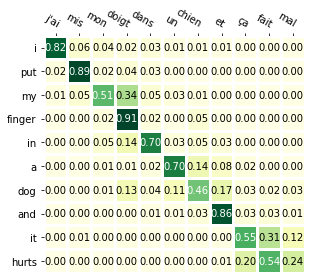

j'ai mis mon doigt dans un chien et ça fait mal  - i
j'ai mis mon doigt dans un chien et ça fait mal  - put
j'ai mis mon doigt dans un chien et ça fait mal  - my
j'ai mis mon doigt dans un chien et ça fait mal  - finger
j'ai mis mon doigt dans un chien et ça fait mal  - in
j'ai mis mon doigt dans un chien et ça fait mal  - a
j'ai mis mon doigt dans un chien et ça fait mal  - dog
j'ai mis mon doigt dans un chien et ça fait mal  - and
j'ai mis mon doigt dans un chien et ça fait mal  - it
j'ai mis mon doigt dans un chien et ça fait mal  - hurts



'i put my finger in a dog and it hurts'

In [136]:
translator_fr_en.eval()
#s = "j'ai le choix dans la date"
#s = "j'ai le doigt dans la chatte, et ça fait mal"
s = "j'ai mis mon doigt dans un chien et ça fait mal"
translator_fr_en(s, attention_method = AttentionViewer)
translator_fr_en(s, attention_method = AttentionViewerOnWords)

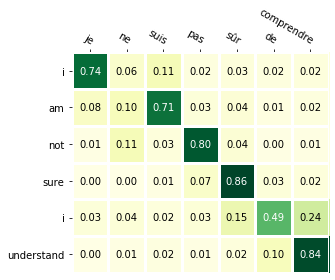

je ne suis pas sûr de comprendre  - i
je ne suis pas sûr de comprendre  - am
je ne suis pas sûr de comprendre  - not
je ne suis pas sûr de comprendre  - sure
je ne suis pas sûr de comprendre  - i
je ne suis pas sûr de comprendre  - understand



'i am not sure i understand'

In [148]:
s = "je ne suis pas sûr de comprendre"
translator_fr_en(s, attention_method = AttentionViewer)
translator_fr_en(s, attention_method = AttentionViewerOnWords)

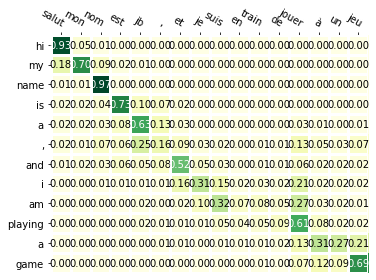

salut mon nom est jb , et je suis en train de jouer à un jeu  - hi
salut mon nom est jb , et je suis en train de jouer à un jeu  - my
salut mon nom est jb , et je suis en train de jouer à un jeu  - name
salut mon nom est jb , et je suis en train de jouer à un jeu  - is
salut mon nom est jb , et je suis en train de jouer à un jeu  - a
salut mon nom est jb , et je suis en train de jouer à un jeu  - ,
salut mon nom est jb , et je suis en train de jouer à un jeu  - and
salut mon nom est jb , et je suis en train de jouer à un jeu  - i
salut mon nom est jb , et je suis en train de jouer à un jeu  - am
salut mon nom est jb , et je suis en train de jouer à un jeu  - playing
salut mon nom est jb , et je suis en train de jouer à un jeu  - a
salut mon nom est jb , et je suis en train de jouer à un jeu  - game



'hi my name is a , and i am playing a game'

In [158]:
translator_fr_en.eval()
s = "salut mon nom est jb, et je suis en train de jouer à un jeu"
translator_fr_en(s, attention_method = AttentionViewer)
translator_fr_en(s, attention_method = AttentionViewerOnWords)

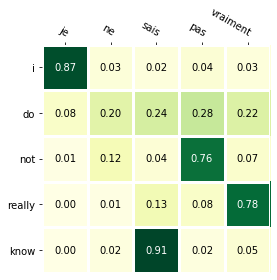

je ne sais pas vraiment  - i
je ne sais pas vraiment  - do
je ne sais pas vraiment  - not
je ne sais pas vraiment  - really
je ne sais pas vraiment  - know



'i do not really know'

In [50]:
translator_fr_en.eval()
sentence = 'je ne sais pas vraiment'
translator_fr_en(sentence, attention_method = AttentionViewer)
translator_fr_en(sentence, attention_method = AttentionViewerOnWords)

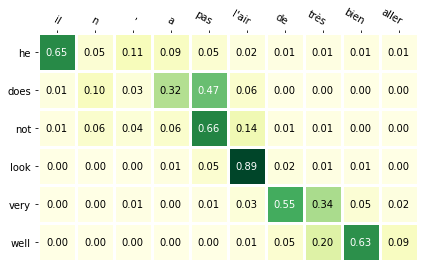

il n ' a pas l'air de très bien aller  - he
il n ' a pas l'air de très bien aller  - does
il n ' a pas l'air de très bien aller  - not
il n ' a pas l'air de très bien aller  - look
il n ' a pas l'air de très bien aller  - very
il n ' a pas l'air de très bien aller  - well



'he does not look very well'

In [88]:
translator_fr_en.eval()
sentence = "il n'a pas l'air de très bien aller"
translator_fr_en(sentence, attention_method = AttentionViewer)
translator_fr_en(sentence, attention_method = AttentionViewerOnWords)

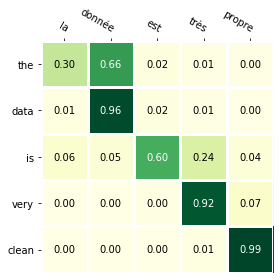

la donnée est très propre  - the
la donnée est très propre  - data
la donnée est très propre  - is
la donnée est très propre  - very
la donnée est très propre  - clean



'the data is very clean'

In [156]:
translator_fr_en.eval()
s = "la donnée est très propre"
translator_fr_en(s, attention_method = AttentionViewer)
translator_fr_en(s, attention_method = AttentionViewerOnWords)

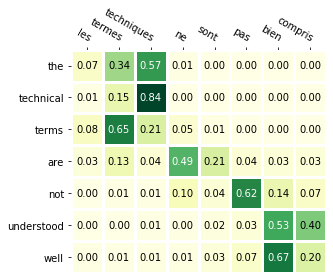

les termes techniques ne sont pas bien compris  - the
les termes techniques ne sont pas bien compris  - technical
les termes techniques ne sont pas bien compris  - terms
les termes techniques ne sont pas bien compris  - are
les termes techniques ne sont pas bien compris  - not
les termes techniques ne sont pas bien compris  - understood
les termes techniques ne sont pas bien compris  - well



'the technical terms are not understood well'

In [163]:
translator_fr_en.eval()
s = "les termes techniques ne sont pas bien compris"
translator_fr_en(s, attention_method = AttentionViewer)
translator_fr_en(s, attention_method = AttentionViewerOnWords)

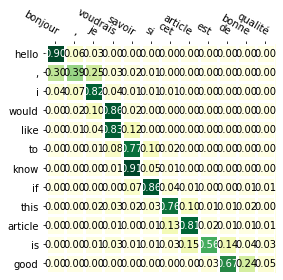

bonjour , je voudrais savoir si cet article est de bonne qualité  - hello
bonjour , je voudrais savoir si cet article est de bonne qualité  - ,
bonjour , je voudrais savoir si cet article est de bonne qualité  - i
bonjour , je voudrais savoir si cet article est de bonne qualité  - would
bonjour , je voudrais savoir si cet article est de bonne qualité  - like
bonjour , je voudrais savoir si cet article est de bonne qualité  - to
bonjour , je voudrais savoir si cet article est de bonne qualité  - know
bonjour , je voudrais savoir si cet article est de bonne qualité  - if
bonjour , je voudrais savoir si cet article est de bonne qualité  - this
bonjour , je voudrais savoir si cet article est de bonne qualité  - article
bonjour , je voudrais savoir si cet article est de bonne qualité  - is
bonjour , je voudrais savoir si cet article est de bonne qualité  - good



'hello , i would like to know if this article is good'

In [96]:
translator_fr_en.eval()
s = "bonjour, je voudrais savoir si cet article est de bonne qualité"
translator_fr_en(s, attention_method = AttentionViewer)
translator_fr_en(s, attention_method = AttentionViewerOnWords)